# 20211012-simpoints
Evaluate IPCs over simpoints for the base prefetchers.

In [22]:
import os
import sys
import glob
from collections import defaultdict

import numpy as np
import pandas as pd
from scipy import stats
import attrdict
import matplotlib.pyplot as plt

---
# User parameters.

You can look at the simpoint-weights or the data to get the trace_id for the trace you want.

In [23]:
trace, trace_id = 'mcf', 429
simpoints_dir = 'data/simpoint-weights/'
results_dir = 'data/base/'

---
# Load simpoint weights and results.

In [24]:
def load_simpoint_weights(simpoints_dir, trace, trace_id):
    """Load simpoint weights for a given trace."""
    simpoints = pd.DataFrame(columns=['trace', 'weight'])
    for f in glob.glob(os.path.join(simpoints_dir, '*.csv')):
        df = pd.read_csv(f)
        simpoints = pd.concat((simpoints, df))
    tr_points = simpoints[simpoints.trace.str.contains(f'{trace_id}.{trace}')]
    weights = np.array(tr_points.weight.array)
    return weights

In [25]:
# Some spec06 traces (that we don't have) don't have an associated trace ID,
# so for now I put 000 as their ID in simpoint-weights.
#
# TODO make a gap simpoint-weights will each trace's simpoints evenly weighted.
simpoint_weights = load_simpoint_weights(simpoints_dir, trace, trace_id)
print(f'{trace_id}.{trace} simpoint weights:', simpoint_weights)

471.omnetpp simpoint weights: [0.0309654 0.954463  0.010929 ]


In [26]:
def parse_champsim_result_file(f, max_instruction_num=None, min_instruction_interval=0):
    data = {
        'instructions': [],
        'cycles': [],
        'heartbeat_ipcs': [],
        'cumulative_ipcs': [],
        'cumulative_sim_times': [],
    }
    
    last_instruction = 0
    warmups_completed = 0 # 0 = none, 1 = CPU, 2 = CPU + prefetch
    for line in f:
        line_tokens = line.split(' ')
        
        # Only append data after the prefetch warmup completes.
        # DEBUG - Hardcoded stop condition (for now. It should stop
        # automatically, but for some reason it doesn't).
        if 'Warmup complete' in line:
            warmups_completed += 1
        
        if 'Heartbeat' in line:
            #print(line)
            instructions = int(line_tokens[line_tokens.index('instructions:') + 1])
            cycles = int(line_tokens[line_tokens.index('cycles:') + 1])
            heartbeat_ipc = float(line_tokens[line_tokens.index('heartbeat') + 2])
            cumulative_ipc = float(line_tokens[line_tokens.index('cumulative') + 2])
            cumulative_sim_time = int(line_tokens[line_tokens.index('time:') + 1]) * 3600 \
                              + int(line_tokens[line_tokens.index('time:') + 3]) * 60 \
                              + int(line_tokens[line_tokens.index('time:') + 5]) \

            # DEBUG - Temporary fix until we can figure out why
            # ChampSim runs too long.
            if max_instruction_num and instructions >= max_instruction_num: 
                warmups_completed = 0
            
            if warmups_completed >= 2 and instructions - last_instruction > min_instruction_interval:
                data['instructions'].append(instructions)
                data['cycles'].append(cycles)
                data['heartbeat_ipcs'].append(heartbeat_ipc)
                data['cumulative_ipcs'].append(cumulative_ipc)
                data['cumulative_sim_times'].append(cumulative_sim_time)
                last_instruction = instructions
    
    return attrdict.AttrDict(data)

def load_champsim_base_results(base, tracename, **kwargs):
    base_path = base + f'/*{tracename}*.txt'
    data = {}
    print('\nLoading ChampSim base prefetcher results from:', base_path)
    variation_paths = glob.glob(base_path)
    for path in variation_paths:
        if '-bo' in os.path.basename(path):
            variation_name = 'bo'
        elif '-sisb_bo' in os.path.basename(path):
            variation_name = 'sisb-bo'
        elif '-sisb-' in os.path.basename(path):
            variation_name = 'sisb'
        elif '-no' in os.path.basename(path):
            variation_name = 'no-prefetcher'
        else:
            continue
            
        print(f'Found variation: {variation_name}')
        with open(path, 'r') as f:
            data[variation_name] = parse_champsim_result_file(
                f, **kwargs
            )
    return data

In [27]:
base_data = []
for i in range(len(simpoint_weights)):
    base_data.append(load_champsim_base_results(
        results_dir, f'{trace_id}.{trace}-s{i}', 
        max_instruction_num=500000000,
        min_instruction_interval=3900000
    ))


Loading ChampSim base prefetcher results from: data/base//*471.omnetpp-s0*.txt
Found variation: no-prefetcher
Found variation: bo
Found variation: sisb
Found variation: sisb-bo

Loading ChampSim base prefetcher results from: data/base//*471.omnetpp-s1*.txt
Found variation: no-prefetcher
Found variation: bo
Found variation: sisb-bo
Found variation: sisb

Loading ChampSim base prefetcher results from: data/base//*471.omnetpp-s2*.txt
Found variation: no-prefetcher
Found variation: bo
Found variation: sisb
Found variation: sisb-bo


---
# Weighted geometric mean IPCs
- Take the weighted geometric mean of IPCs for the given trace, using the simpoint weights.

In [28]:
def get_simpoint_ipcs(results):
    """Parse the results dictionary to get an array
    of simpoint IPCs for each prefetcher. For prefetcher 
    p, simpoint_ipcs[p][i] is the cumulative IPC of p on
    simpoint s_i.
    """
    num_simpoints = len(results)
    simpoint_ipcs = defaultdict(lambda : np.zeros(num_simpoints, dtype=np.float32)) # Simpoint IPCs organized by prefetcher.
    for spidx, sp in enumerate(results):
        for pf in sp:
            # TODO handle missing / incomplete traces automatically 
            # (instead of using a debug if statement here to filter 
            # out unfinished runs)
            simpoint_ipcs[pf][spidx] = sp[pf].cumulative_ipcs[-1] 
    return simpoint_ipcs


def get_mean_ipcs(results, simpoint_weights):
    """Calculate the weighted geometric mean cumulative IPC 
    of each prefetcher over the simpoints.
    """
    simpoint_ipcs = get_simpoint_ipcs(results)
    mean_ipcs = {}
    for pf in simpoint_ipcs:
        mean_ipcs[pf] = stats.mstats.gmean(simpoint_ipcs[pf], weights=simpoint_weights)
    return mean_ipcs


def get_mean_ipc_speedups(results, simpoint_weights, baseline_prefetcher='no-prefetcher'):
    """Calcualte the weighted geometric mean cumulative IPC
    of each prefetcher, then compare it against the weighted 
    geometric mean of the baseline prefetcher, to get speedup.
    
    TODO - is the above method correct?
    """
    mean_ipcs = get_mean_ipcs(results, simpoint_weights)
    mean_ipc_baseline = mean_ipcs[baseline_prefetcher]
    mean_ipc_speedups = {}
    for pf in mean_ipcs:
        mean_ipc_speedups[pf] = mean_ipcs[pf] - mean_ipc_baseline
    return mean_ipc_speedups
        

# Cumulative IPCs for each simpoint.
simpoint_ipcs = get_simpoint_ipcs(base_data)
print('Per-simpoint cumulative IPCs:')
print(simpoint_ipcs)

# Weighted geometric mean cumulative IPC, for all simpoints.
mean_ipcs = get_mean_ipcs(base_data, simpoint_weights)
print('\nWGM cumulative IPCs:')
print(mean_ipcs)

# Weighted geometric mean IPC speedup, for all simpoints, vs. no prefetcher
mean_ipc_speedups = get_mean_ipc_speedups(base_data, simpoint_weights)
print('\nWGM IPC speedups:')
print(mean_ipc_speedups)

Per-simpoint cumulative IPCs:
defaultdict(<function get_simpoint_ipcs.<locals>.<lambda> at 0x7fb2f448cdc0>, {'no-prefetcher': array([0.567865, 0.30875 , 0.448416], dtype=float32), 'bo': array([0.56744 , 0.325099, 0.445005], dtype=float32), 'sisb': array([0.608949, 0.456205, 0.468475], dtype=float32), 'sisb-bo': array([0.598534, 0.434406, 0.453764], dtype=float32)})

WGM cumulative IPCs:
{'no-prefetcher': 0.31594344701597943, 'bo': 0.3319168458074625, 'sisb': 0.46045202646582417, 'sisb-bo': 0.4389645536306793}

WGM IPC speedups:
{'no-prefetcher': 0.0, 'bo': 0.015973398791483073, 'sisb': 0.14450857944984474, 'sisb-bo': 0.1230211066146999}


## Plot (weighted geometric) mean IPCs

In [29]:
trace_name = f'{trace_id}.{trace}'

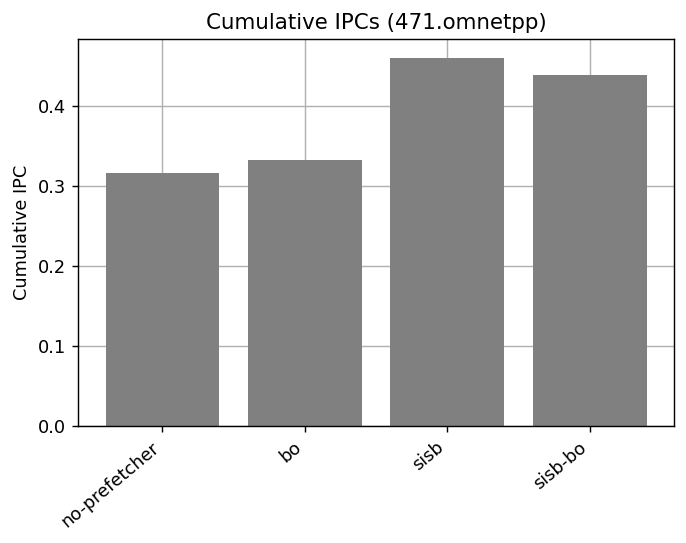

In [30]:
def plot_mean_ipcs(mean_ipcs, sweep_name='', trace_name=''):
    """Plot (weighted geometric) mean IPCs for a
    list of prefetchers.
    """
    fig, ax = plt.subplots(dpi=128)
    ax.grid()
    ax.set_axisbelow(True) # Plot grid under bars.
    
    labels = []
    i = 0
    for pf, pf_mean_ipc in mean_ipcs.items():
        ax.bar(
            i, pf_mean_ipc,
            color = 'gray'
        )
        labels.append(pf)
        i += 1
        
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=40, ha='right')
    
    title = 'Cumulative IPCs'
    if sweep_name:
        title += f' ({sweep_name})'
    if trace_name:
        title += f' ({trace_name})'
    ax.set_title(title)
    ax.set_ylabel('Cumulative IPC')
        
plot_mean_ipcs(mean_ipcs, trace_name=trace_name)

## Plot (weighted geometric) mean IPC speedups

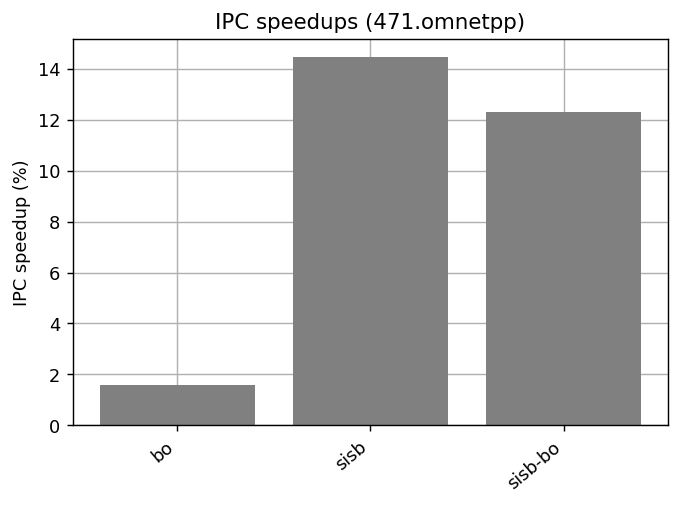

In [31]:
def plot_mean_ipc_speedups(mean_ipc_speedups, sweep_name='', trace_name=''):
    """Plot (weighted geometric) mean IPC speedups for a
    list of prefetchers.
    """
    fig, ax = plt.subplots(dpi=128)
    ax.grid()
    ax.set_axisbelow(True) # Plot grid under bars.
    
    labels = []
    i = 0
    for pf, pf_mean_ipc_speedup in mean_ipc_speedups.items():
        if pf == 'no-prefetcher': # No need to plot. (it's the baseline)
            continue
            
        ax.bar(
            i, pf_mean_ipc_speedup * 100.,
            color = 'gray'
        )
        labels.append(pf)
        i += 1
        
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=40, ha='right')
    
    title = 'IPC speedups'
    if sweep_name:
        title += f' ({sweep_name})'
    if trace_name:
        title += f' ({trace_name})'
    ax.set_title(title)
    ax.set_ylabel('IPC speedup (%)')
        
plot_mean_ipc_speedups(mean_ipc_speedups, trace_name=trace_name)